In [1]:
import sys
from pathlib import Path
from os.path  import join
from src.config import DATA_DIR, CONFIG_DIR, MODELS_DIR
from omegaconf import OmegaConf
from src.external.hptr.src.data_modules.agent_centric import AgentCentricPreProcessing
from src.external.hptr.src.data_modules.ac_global import AgentCentricGlobal
from src.mimolm import InputProjections, EarlyFusionEncoder, MotionDecoder
import torch
import torch.nn.functional as F
import lightning as pl
from collections import OrderedDict
import torch.nn as nn
from tqdm import tqdm
import numpy as np

# Add the project root to sys.path
project_root = Path().resolve().parent  # Adjust as needed to point to the root folder
sys.path.append(str(project_root))

print(Path.cwd())  # Check if the path is added

2025-02-15 20:51:03.059 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/harshavardhan-patil/Work/Projects/mimolm


/home/harshavardhan-patil/Work/Projects/mimolm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/harshavardhan-patil/Work/Projects/mimolm/notebooks


In [2]:
from src.external.hptr.src.data_modules.data_h5_av2 import DataH5av2
from src.mimolm import MimoLM
from lightning.pytorch.callbacks import LearningRateMonitor

torch.set_printoptions(threshold=10000, sci_mode=False)
data_module = DataH5av2(DATA_DIR)
data_module.setup(stage="fit")
train_loader = data_module.train_dataloader()
# val_loader = data_module.val_dataloader()

preprocessor = nn.Sequential(OrderedDict([
            ('pre_1', AgentCentricPreProcessing(sampling_rate = 5,
                                        time_step_current=49, 
                                        n_target=8,
                                        n_other=48,
                                        n_map=512,
                                        mask_invalid=False)),
            ('pre_2', AgentCentricGlobal(sampling_rate = 5,
                                data_size=data_module.tensor_size_train,
                               time_step_current=49,
                                dropout_p_history=0.1, 
                                add_ohe=True,
                                pl_aggr=False,
                                pose_pe= {"agent": "xy_dir",
                                        "map": "mpa_pl"}))
                                        ]))

decoder = MotionDecoder(max_delta = 2.0, #meters
                                n_quantization_bins = 128,
                                n_verlet_steps = 13,
                                emb_dim = 256,
                                enc_dim = 128,
                                sampling_rate = 5,
                                n_time_steps = 110,
                                n_target = 5, #should be same as AgentCentricProcessing
                                time_step_end = 49,
                                dropout_rate = 0.2,
                                n_rollouts = 1,
                                n_heads = 2,
                                n_layers = 2,)

def tokenize_motion(motion_tokens, pos_bins, verlet_wrapper, n_verlet_steps):
    # delta_x and delta_y
    motion_tokens = torch.diff(motion_tokens, dim=2, prepend=motion_tokens[:, :, :1, :])
    invalid_indices = torch.cat(((motion_tokens < -8.0).nonzero()
                                 , (motion_tokens > 8.0).nonzero()
                                 , (motion_tokens == 0.).nonzero()))
    # MotionLM uses greedy search, using bucketize here for simplicity
    x_tokens = torch.bucketize(motion_tokens[:, :, :, 0].contiguous(), pos_bins,)
    y_tokens = torch.bucketize(motion_tokens[:, :, :, 1].contiguous(), pos_bins,)
    x_last = x_tokens[:, :, -1].unsqueeze(-1)
    y_last = y_tokens[:, :, -1].unsqueeze(-1)
    x_tokens_diff = torch.diff(x_tokens, dim=2, prepend = x_tokens[:, :, :1])
    y_tokens_diff = torch.diff(y_tokens, dim=2, prepend = y_tokens[:, :, :1])
    # Verlet Wrapper (see paper): The idea is that velocity of cars changes smoothly, so we can use a smaller vocabulary to represent the relative motion between the last two time steps.
    # e.g: max_delta: float = 4.0,  n_quantization_bins: int = 128,  n_verlet_steps: int = 13, 10 Hz predicition, 
    # the max speed for the modeled agent is 4 x 10 = 40 m/s. 0 to max steps in Verlet Wrapper represents the max distance delta modeled. For -6 to 6 with 13 steps in Verlet and for 128 bins, the max acceleration between timesteps is 3.1 m/s^2.
    x_tokens = torch.clamp(torch.bucketize(x_tokens_diff, verlet_wrapper,), min = 0, max = n_verlet_steps - 1)
    y_tokens = torch.clamp(torch.bucketize(y_tokens_diff, verlet_wrapper,), min = 0, max = n_verlet_steps - 1)
    # collapse the per-coordinate actions to a single integer indexing into their Cartesian product
    mask = torch.ones_like(motion_tokens, dtype=bool)
    mask[invalid_indices[:, 0], invalid_indices[:, 1], invalid_indices[:, 2]] = 0.
    cart_prod = torch.tensor(x_tokens * n_verlet_steps + y_tokens) 
    # invalid tokens
    cart_prod[invalid_indices[:, 0], invalid_indices[:, 1], invalid_indices[:, 2]] = n_verlet_steps ** 2
    return cart_prod, torch.cat((x_last, y_last), dim=-1), motion_tokens[mask]

In [ ]:
verlet_indices = torch.tensor([0] * 170)
motion_diffs = []
i = 0
inds = None
for batch in tqdm(train_loader):
    batch = preprocessor(batch)
    a = torch.cat((batch["ac/target_pos"], batch["gt/pos"][:, :, ::2,]), dim = -2)
    actuals, _, diff = tokenize_motion(a,
                torch.tensor([    -7.9939,     -0.4938,     -0.2846,     -0.1980,     -0.1502,
            -0.1189,     -0.0965,     -0.0798,     -0.0668,     -0.0567,
            -0.0486,     -0.0420,     -0.0366,     -0.0321,     -0.0283,
            -0.0251,     -0.0222,     -0.0198,     -0.0177,     -0.0158,
            -0.0141,     -0.0127,     -0.0114,     -0.0102,     -0.0091,
            -0.0082,     -0.0073,     -0.0066,     -0.0059,     -0.0052,
            -0.0047,     -0.0042,     -0.0037,     -0.0033,     -0.0029,
            -0.0025,     -0.0022,     -0.0019,     -0.0016,     -0.0014,
            -0.0011,     -0.0009,     -0.0008,     -0.0006,     -0.0005,
            -0.0003,     -0.0002,     -0.0001,     -0.0000,      0.0000,
             0.0001,      0.0002,      0.0003,      0.0004,      0.0005,
             0.0007,      0.0009,      0.0010,      0.0013,      0.0015,
             0.0018,      0.0020,      0.0024,      0.0027,      0.0031,
             0.0035,      0.0040,      0.0045,      0.0051,      0.0057,
             0.0064,      0.0071,      0.0079,      0.0088,      0.0099,
             0.0110,      0.0123,      0.0137,      0.0153,      0.0171,
             0.0191,      0.0214,      0.0241,      0.0271,      0.0306,
             0.0347,      0.0396,      0.0455,      0.0526,      0.0614,
             0.0722,      0.0857,      0.1021,      0.1225,      0.1471,
             0.1756,      0.2070,      0.2392,      0.2706,      0.3052,
             0.3524,      0.4173,      0.4906,      0.5701,      0.6557,
             0.7445,      0.8357,      0.9277,      1.0204,      1.1134,
             1.2091,      1.3028,      1.3969,      1.4933,      1.5916,
             1.6917,      1.7857,      1.8866,      1.9888,      2.0931,
             2.1836,      2.2850,      2.4269,      2.5881,      2.7416,
             2.9925,      3.2802,      7.9987]),
                decoder.verlet_wrapper, 
                decoder.n_verlet_steps)
    actuals = actuals.flatten(0, -1)
    verlet_indices += np.bincount(actuals, minlength=170)
    motion_diffs.extend(diff.tolist())
    i+=1
    if i == 10:
        break

  0%|          | 0/781 [00:00<?, ?it/s]/tmp/ipykernel_8833/2936229932.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cart_prod = torch.tensor(x_tokens * n_verlet_steps + y_tokens)
/tmp/ipykernel_8833/4489562.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  verlet_indices += np.bincount(actuals, minlength=170)
  1%|          | 9/781 [00:36<51:37,  4.01s/it]  


In [4]:
data = motion_diffs

summary = {
    "Min": float(np.min(data)),
    "Max": float(np.max(data)),
    "Mean": float(np.mean(data)),
    "Median": float(np.median(data)),
    "Std Dev": float(np.std(data)),
    "10th Percentile": float(np.percentile(data, 10)),
    "25th Percentile (Q1)": float(np.percentile(data, 25)),
    "50th Percentile (Median)": float(np.percentile(data, 50)),
    "75th Percentile (Q3)": float(np.percentile(data, 75)),
    "90th Percentile": float(np.percentile(data, 90)),
    "99th Percentile": float(np.percentile(data, 99)),
}

summary

{'Min': -7.9939284324646,
 'Max': 7.998668670654297,
 'Mean': 0.34422423769383087,
 'Median': 0.0029113590717315674,
 'Std Dev': 0.7850835142761968,
 '10th Percentile': -0.03340655565261841,
 '25th Percentile (Q1)': -0.0037962438073009253,
 '50th Percentile (Median)': 0.0029113590717315674,
 '75th Percentile (Q3)': 0.1832500770688057,
 '90th Percentile': 1.6212667465209964,
 '99th Percentile': 3.1654281616210938}

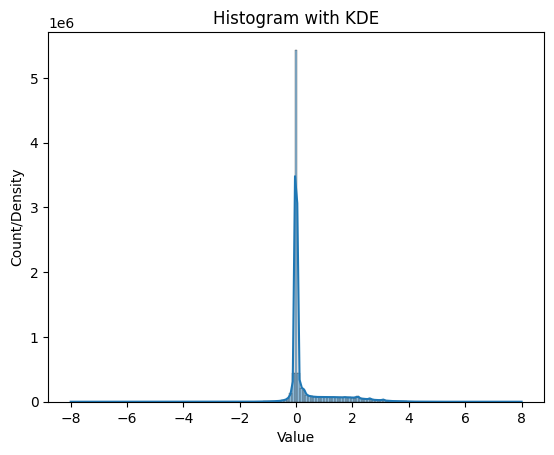

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(np.clip(data, -8.0, 8.0), bins=169, kde=True)

plt.xlabel("Value")
plt.ylabel("Count/Density")
plt.title("Histogram with KDE")

plt.show()


In [14]:
torch.quantile(torch.tensor([data]), torch.linspace(0, 1, steps=128))

tensor([    -7.9939,     -0.4938,     -0.2846,     -0.1980,     -0.1502,
            -0.1189,     -0.0965,     -0.0798,     -0.0668,     -0.0567,
            -0.0486,     -0.0420,     -0.0366,     -0.0321,     -0.0283,
            -0.0251,     -0.0222,     -0.0198,     -0.0177,     -0.0158,
            -0.0141,     -0.0127,     -0.0114,     -0.0102,     -0.0091,
            -0.0082,     -0.0073,     -0.0066,     -0.0059,     -0.0052,
            -0.0047,     -0.0042,     -0.0037,     -0.0033,     -0.0029,
            -0.0025,     -0.0022,     -0.0019,     -0.0016,     -0.0014,
            -0.0011,     -0.0009,     -0.0008,     -0.0006,     -0.0005,
            -0.0003,     -0.0002,     -0.0001,     -0.0000,      0.0000,
             0.0001,      0.0002,      0.0003,      0.0004,      0.0005,
             0.0007,      0.0009,      0.0010,      0.0013,      0.0015,
             0.0018,      0.0020,      0.0024,      0.0027,      0.0031,
             0.0035,      0.0040,      0.0045,     

In [23]:
verlet_indices

tensor([ 19880,   2677,   3416,   4476,   5707,   6861,   8442,   6847,   5753,
          4194,   3224,   2462,  18949,   2142,    458,    608,    852,   1349,
          1525,   1925,   1602,   1182,    902,    585,    416,   2134,   2821,
           609,    854,   1208,   1761,   2084,   2695,   2160,   1727,   1146,
           771,    607,   2678,   3732,    805,   1195,   1702,   2484,   3202,
          4090,   3259,   2440,   1583,   1151,    827,   3698,   5724,   1203,
          1657,   2580,   3736,   5149,   7570,   5261,   3607,   2341,   1542,
          1045,   5342,  11595,   2279,   3260,   4786,   7578,  12780,  20995,
         12874,   7561,   4536,   3093,   2161,  11254,  26587,   5092,   6972,
         10514,  17555,  33198,  67617,  34275,  18397,  10546,   6902,   4911,
         26135,  10858,   2058,   3006,   4433,   7029,  12207,  20777,  12408,
          7292,   4713,   3062,   2154,  10908,   5330,   1130,   1556,   2239,
          3603,   5098,   7465,   4896, 

In [26]:
verlet_indices[84]

tensor(67617)

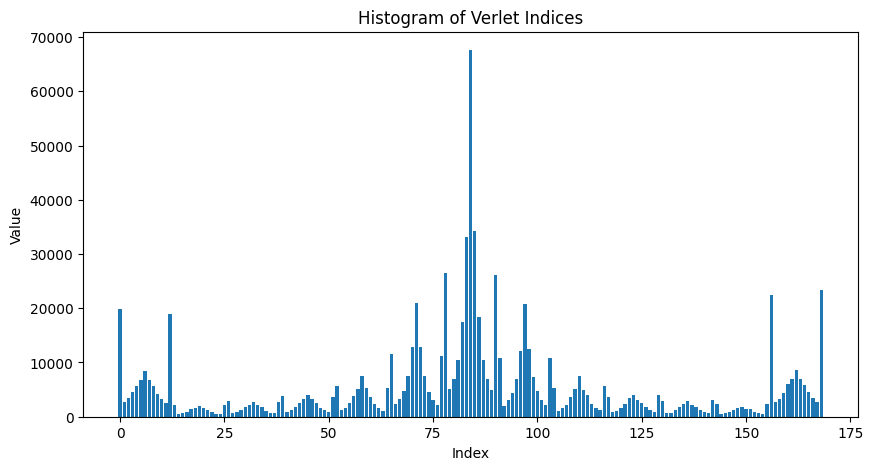

In [22]:
plt.figure(figsize=(10, 5))
plt.bar(torch.arange(len(verlet_indices) - 1), verlet_indices[:-1])

# Labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Histogram of Verlet Indices")

# Show the plot
plt.show()

In [4]:
verlet_indices = torch.tensor([0] * 170)
motion_diffs = []
i = 0
v = None
for batch in tqdm(train_loader):
    batch = preprocessor(batch)
    v = batch['input/target_valid']
    a = torch.cat((batch["ac/target_pos"], batch["gt/pos"][:, :, ::2,]), dim = -2)
    actuals, _, diff = tokenize_motion(a,
                decoder.pos_bins, 
                decoder.verlet_wrapper, 
                decoder.n_verlet_steps)
    b = actuals
    actuals = actuals.flatten(0, -1)
    verlet_indices += np.bincount(actuals, minlength=170)
    motion_diffs.extend(diff.tolist())
    x = diff
    if diff[0].max() > 8.0:
        break
    i += 1
    if i > 1:
        break
 

  0%|          | 0/199908 [00:00<?, ?it/s]/tmp/ipykernel_10250/1194342471.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cart_prod = torch.tensor(x_tokens * n_verlet_steps + y_tokens)
/tmp/ipykernel_10250/2560174625.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  verlet_indices += np.bincount(actuals, minlength=170)
  0%|          | 1/199908 [00:00<15:32:43,  3.57it/s]


In [5]:
v

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False,  True,  True,  True,  True],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False,  True,  True,  True,
           True,  True,  True,  True,  True],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
           True,

In [6]:
b

tensor([[[169, 164, 163, 163, 162, 110,  71,  96,  97, 110,  97, 110, 111, 124,
          110,  85,  83,  84,  83,  83,  84,  84,  84,  83,  83,  83,  83,  85,
           84,  84,  85,  84,  84,  83,  84,  84,  83,  84,  84,  85,  83,  85,
           84,  84,  84,  84,  84,  84,  84,  83,  84,  84,  85,  84,  71],
         [169, 162, 161, 162, 148,  96,  57,  96,  96,  84,  96,  84,  83,  85,
           84,  84,  85,  85,  72,  85,  72,  59,  72,  71,  71,  84,  71,  45,
           45,  45,  45,  58,  84,  97, 110, 123, 123, 123, 123, 110, 110,  97,
           97,  84,  97,  84,  84,  71,  84,  84,  97, 111,  44,   6,   6],
         [169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169,
          169, 169, 169, 169, 169, 169, 169, 169, 156,  85,  87,  88,  85,  84,
           83,  82,  84,  82, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169,
          169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169],
         [169, 169, 169, 169, 169, 169, 169, 169, 16

In [66]:
a

tensor([[[[   -48.6440,     -2.6794],
          [   -47.8925,     -2.6165],
          [   -46.8147,     -2.5244],
          [   -45.4601,     -2.4040],
          [   -43.9036,     -2.2661],
          [   -42.3101,     -2.1316],
          [   -40.7393,     -2.0136],
          [   -39.1401,     -1.9120],
          [   -37.5023,     -1.8213],
          [   -35.8092,     -1.7356],
          [   -34.0728,     -1.6516],
          [   -32.2890,     -1.5505],
          [   -30.4355,     -1.4220],
          [   -28.4883,     -1.2625],
          [   -26.4741,     -1.0898],
          [   -24.3733,     -0.9157],
          [   -22.1807,     -0.7457],
          [   -19.8648,     -0.6002],
          [   -17.4304,     -0.4787],
          [   -14.9562,     -0.3695],
          [   -12.4311,     -0.2706],
          [    -9.8371,     -0.1805],
          [    -7.1847,     -0.0940],
          [    -4.4385,     -0.0342],
          [    -1.5307,     -0.0054],
          [     1.5713,     -0.0022],
          [ 

In [15]:
a

tensor([[[[  20.7997,   30.4386],
          [ -42.7161,    5.1916],
          [  26.8506,   35.0742],
          ...,
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000]],

         [[  20.4423,   30.2860],
          [ -43.3839,    4.8765],
          [  26.5564,   34.9151],
          ...,
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000]],

         [[  19.9977,   30.0976],
          [ -44.2437,    4.4706],
          [  26.1876,   34.7147],
          ...,
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000]],

         ...,

         [[ -57.2254,   -0.7752],
          [   0.0000,    0.0000],
          [-100.4531,  -23.4945],
          ...,
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000]],

         [[ -57.6910,   -0.9831],
          [   0.0000,    0.0000],
          [-101.2876,  -23.8528],

In [ ]:
np.linalg.norm([[     9.4798,     -0.2392],
          [   137.8498,     16.3927],])

np.float64(139.14457157219607)

In [28]:
(a == 137.8498).nonzero(as_tuple=True)

(tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64))